In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#reading from pickle
with open('processed_df_final.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60434 entries, 0 to 65868
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          60434 non-null  object 
 1   album_name        60434 non-null  object 
 2   artists           60434 non-null  object 
 3   track_name        60434 non-null  object 
 4   track_genre       60434 non-null  object 
 5   duration_ms       60434 non-null  int64  
 6   explicit          60434 non-null  int64  
 7   href              60434 non-null  object 
 8   danceability      60434 non-null  float64
 9   energy            60434 non-null  float64
 10  loudness          60434 non-null  float64
 11  mode              60434 non-null  int64  
 12  speechiness       60434 non-null  float64
 13  acousticness      60434 non-null  float64
 14  instrumentalness  60434 non-null  float64
 15  liveness          60434 non-null  float64
 16  valence           60434 non-null  float6

In [4]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [5]:
df_vect = df.copy()

In [6]:
# creating a custom tokenizer that will only split words based on white space since multi-word genres 
# are formatted with dashes (-) to between the words
def my_tokenizer(text):
    # Split text into tokens based on whitespace characters
    tokens = re.split(r'\s+', text)
    return tokens

In [7]:
bagofwords = CountVectorizer(tokenizer=my_tokenizer).fit(df_vect['track_genre'])

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
transformed = bagofwords.transform(df_vect['track_genre'])

In [9]:
vect_matrix = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed.toarray())
vect_matrix.head()

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,bossanova,...,summer,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,work-out,world-music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_vect = pd.concat([df_vect.reset_index(),vect_matrix],axis=1)

In [11]:
df_vect['popularity'] = np.where(df_vect['popularity'] >= np.median(df_vect['popularity']), 1, 0)

In [13]:
df_vect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60434 entries, 0 to 60433
Columns: 149 entries, index to world-music
dtypes: float64(11), int64(131), object(7)
memory usage: 68.7+ MB


In [14]:
vect_rem, vect_test = train_test_split(df_vect, test_size=0.25, random_state=42,
                                     stratify=df_vect[['track_genre','popularity']])

### Train and validation checking

In [14]:
vect_train, vect_validation = train_test_split(vect_rem, test_size=0.25, random_state=42,
                                     stratify=vect_rem[['track_genre','popularity']])

In [16]:
X_train = vect_train.drop(columns='popularity')
y_train = vect_train['popularity']
X_val = vect_validation.drop(columns='popularity')
y_val = vect_validation['popularity']

In [18]:
X_train.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url'],inplace=True)
X_val.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url'],inplace=True)

In [19]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_val_ss = scaler.transform(X_val)

In [55]:
#X_rem = vect_train.drop(columns='popularity')
#y_rem = vect_train['popularity']
#X_test = vect_test.drop(columns='popularity')
#y_test = vect_test['popularity']

In [26]:
train_acc = []
val_acc = []
for x in [0.3,0.35,0.4,0.45,0.5,0.55,0.6]:
    xgb = XGBClassifier(learning_rate=x).fit(X_train_ss,y_train)
    train_acc.append(accuracy_score(xgb.predict(X_train_ss),y_train))
    val_acc.append(accuracy_score(xgb.predict(X_val_ss),y_val))

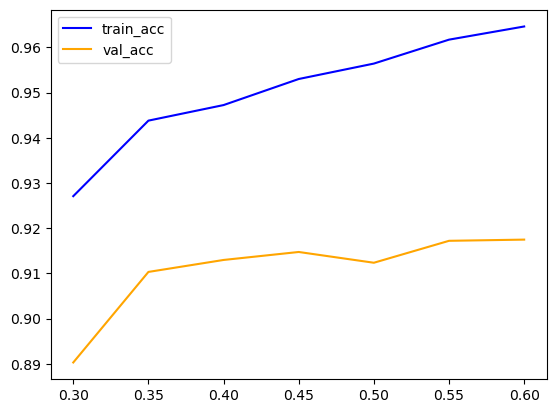

In [28]:
plt.figure()
plt.plot([0.3,0.35,0.4,0.45,0.5,0.55,0.6], train_acc, color='blue', label='train_acc')
plt.plot([0.3,0.35,0.4,0.45,0.5,0.55,0.6], val_acc, color='orange', label='val_acc')
plt.legend()
plt.show()

In [29]:
train_acc = []
val_acc = []
for x in [0.5,0.55,0.6,0.65,0.7]:
    xgb = XGBClassifier(learning_rate=x).fit(X_train_ss,y_train)
    train_acc.append(accuracy_score(xgb.predict(X_train_ss),y_train))
    val_acc.append(accuracy_score(xgb.predict(X_val_ss),y_val))

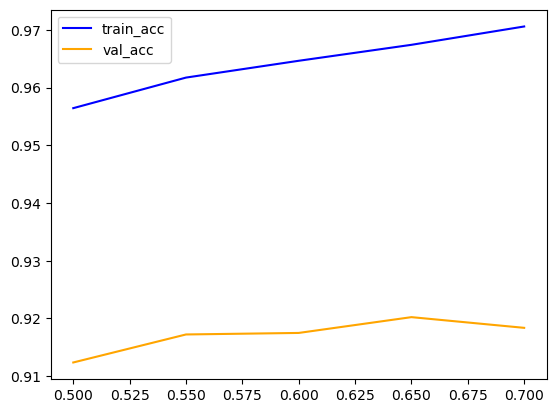

In [30]:
plt.figure()
plt.plot([0.5,0.55,0.6,0.65,0.7], train_acc, color='blue', label='train_acc')
plt.plot([0.5,0.55,0.6,0.65,0.7], val_acc, color='orange', label='val_acc')
plt.legend()
plt.show()

### Grid Search

In [20]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.05, 0.1, 0.3],
    'xgb__n_estimators': [50,100],
    'xgb__gamma':[0, 0.1, 0.2],
   # 'xgb__subsample': [0.5, 0.7, 0.9], for overfitting purposes
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_train_ss, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                  

In [21]:
grid.best_score_

0.8977606177606179

In [44]:
grid.best_score_

0.8977606177606179

In [28]:
pd.DataFrame(grid.cv_results_).iloc[5,:]['params']

{'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__n_estimators': 100}

In [31]:
xgboost = XGBClassifier(gamma=0,learning_rate=0.3,n_estimators=100).fit(X_train_ss,y_train)

In [32]:
y_pred = xgboost.predict(X_train_ss)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

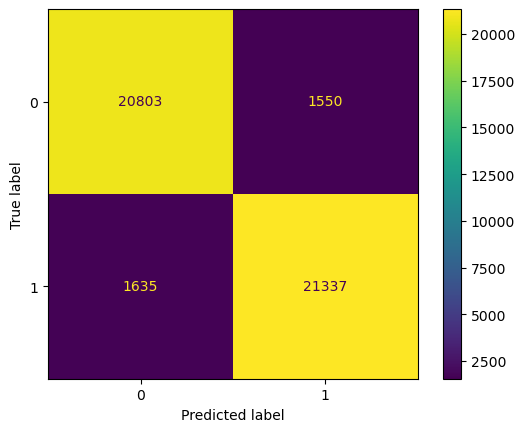

In [35]:
cm = confusion_matrix(y_pred,y_train)
ConfusionMatrixDisplay(cm).plot()

In [36]:
f1_score(y_pred,y_train)

0.9305479840380295

In [37]:
recall_score(y_pred,y_train)

0.9288263973532996

In [38]:
precision_score(y_pred,y_train)

0.932275964521344

In [40]:
accuracy_score(y_pred,y_train)

0.9297297297297298

In [45]:
xgboost1 = XGBClassifier().fit(X_train_ss,y_train)

In [47]:
xgboost1.score(X_train_ss,y_train)

0.9297297297297298

In [49]:
pd.DataFrame(y_train).value_counts(normalize=True)

popularity
1             0.504953
0             0.495047
dtype: float64

### The Over night grid search

In [16]:
X_rem = vect_rem.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url','popularity'])
y_rem = vect_rem['popularity']

In [19]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.3,0.4,0.5],
    'xgb__n_estimators': [50,100],
    'xgb__gamma':[0, 0.25, 0.5],
    'xgb__subsample': [0.5, 0.7, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [20]:
grid.best_score_

0.9135576392719249

In [22]:
grid.best_params_

{'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.5,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.9}

In [24]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.5,0.6,0.7],
    'xgb__n_estimators': [100,150,200],
    'xgb__gamma':[0.2, 0.25, 0.3],
    'xgb__subsample': [0.8, 0.85, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_2.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [25]:
grid.best_score_

0.9245670159955874

In [26]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.9}

In [27]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.45,0.5,0.55],
    'xgb__n_estimators': [200,250,300],
    'xgb__gamma':[0.15, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_3.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [30]:
grid.best_score_

0.9266850523993382

In [32]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.45,
 'xgb__n_estimators': 250,
 'xgb__subsample': 0.9}

In [34]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.43,0.45,0.47],
    'xgb__n_estimators': [225,250,375],
    'xgb__gamma':[0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_4.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [35]:
grid.best_score_

0.9269939327082184

In [36]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.43,
 'xgb__min_child_weight': 0.5,
 'xgb__n_estimators': 375,
 'xgb__subsample': 0.9}